In [1]:
import ijson
import pandas as pd
import seaborn as sns
import scikitplot as skplt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
%matplotlib inline

## Load Data

In [2]:
filename = "games.json"
with open(filename, 'r') as f:
    data = ijson.items(f,"")
    data = list(data)[0]
    # print(data)
    df = pd.DataFrame(data)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154630 entries, 0 to 154629
Data columns (total 30 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   gameId                       154630 non-null  object
 1   gameCreation                 154630 non-null  object
 2   gameDuration                 154630 non-null  int64 
 3   playerId                     154630 non-null  object
 4   teamId                       154630 non-null  object
 5   championId                   154630 non-null  object
 6   win                          154630 non-null  bool  
 7   kills                        154630 non-null  int64 
 8   deaths                       154630 non-null  int64 
 9   assists                      154630 non-null  int64 
 10  largestKillingSpree          154630 non-null  int64 
 11  largestMultiKill             154630 non-null  int64 
 12  killingSprees                154630 non-null  int64 
 13  longestTimeSpe

## Feature Engineering - Player Level

In [4]:
def features(row):
    goldpermin = row.goldEarned/(row.gameDuration/60)
    dmgpergold = row.totalDamageDealtToChampions/row.goldEarned
    healpergold = (row.totalHeal)/row.goldEarned
    ccpermin =  (row.timeCCingOthers)/(row.gameDuration/60)
    dmgTurretPerMin = row.damageDealtToTurrets/(row.gameDuration/60)
    dmgObjPerMin = row.damageDealtToObjectives/(row.gameDuration/60)
    visionPerMin = row.visionScore/(row.gameDuration/60)
    champLevelPerMin =  row.champLevel/(row.gameDuration/60)
    kda = (row.kills + row.assists)/max([row.deaths,1])
    return pd.Series([goldpermin, dmgpergold,healpergold,ccpermin,dmgTurretPerMin,dmgObjPerMin,visionPerMin,champLevelPerMin,kda])



In [5]:
df[['goldpermin', 'dmgpergold','healpergold','ccpermin','dmgTurretPerMin','dmgObjPerMin','visionPerMin','champLevelPerMin','kda']] = df.apply(features ,axis=1)

dropColumns = ["playerId","gameId","gameCreation","gameDuration","championId","doubleKills","tripleKills","quadraKills",
               "teamId","killingSprees","firstBlood","firstTower","visionScore","champLevel","goldEarned",
              "totalDamageDealtToChampions","totalHeal","timeCCingOthers"]
data = df.drop(columns=dropColumns)

data = pd.get_dummies(data, drop_first=True)
data.head()

,win,kills,deaths,assists,largestKillingSpree,largestMultiKill,longestTimeSpentLiving,pentaKills,damageDealtToObjectives,damageDealtToTurrets,...,firstInhibitor,goldpermin,dmgpergold,healpergold,ccpermin,dmgTurretPerMin,dmgObjPerMin,visionPerMin,champLevelPerMin,kda
0,False,4,15,10,0,1,259,0,7950,0,...,False,292.378176,1.216581,0.639744,1.024573,0.000000,198.667222,0.724698,0.374844,0.933333
1,False,9,14,13,2,2,456,0,6264,3446,...,False,410.778842,2.199051,0.334651,0.224906,86.114119,156.534777,0.774677,0.399833,1.571429
2,False,7,4,6,4,2,630,0,13417,12241,...,False,380.091628,1.663971,0.451874,0.574761,305.897543,335.285298,1.199500,0.449813,3.250000
3,False,8,10,11,3,2,614,0,5181,49,...,False,305.997501,2.983748,0.086974,0.449813,1.224490,129.471054,1.774261,0.374844,1.900000
4,False,10,11,10,3,1,726,0,4014,0,...,False,344.656393,2.853538,0.090270,0.974594,0.000000,100.308205,0.724698,0.424823,1.818182


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154630 entries, 0 to 154629
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   win                      154630 non-null  bool   
 1   kills                    154630 non-null  int64  
 2   deaths                   154630 non-null  int64  
 3   assists                  154630 non-null  int64  
 4   largestKillingSpree      154630 non-null  int64  
 5   largestMultiKill         154630 non-null  int64  
 6   longestTimeSpentLiving   154630 non-null  int64  
 7   pentaKills               154630 non-null  int64  
 8   damageDealtToObjectives  154630 non-null  int64  
 9   damageDealtToTurrets     154630 non-null  int64  
 10  totalDamageTaken         154630 non-null  int64  
 11  firstInhibitor           154630 non-null  bool   
 12  goldpermin               154630 non-null  float64
 13  dmgpergold               154630 non-null  float64
 14  heal

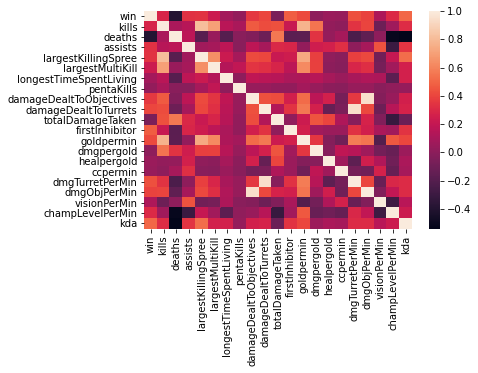

In [7]:
# calculate the correlation matrix
corr = data.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [8]:
data.corr().unstack().sort_values().drop_duplicates()

kda                  deaths                    -0.540248
deaths               champLevelPerMin          -0.512195
win                  deaths                    -0.390598
champLevelPerMin     totalDamageTaken          -0.316669
assists              champLevelPerMin          -0.301668
                                                  ...   
kills                goldpermin                 0.776485
largestKillingSpree  kills                      0.819197
dmgTurretPerMin      damageDealtToTurrets       0.947625
dmgObjPerMin         damageDealtToObjectives    0.950506
win                  win                        1.000000
Length: 211, dtype: float64

## Feature Importance

In [9]:
X = data.loc[:, data.columns != "win"]
y = data.loc[:, "win"]

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# scale
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# benchmark models
lr = LogisticRegression(max_iter=500)
dt = DecisionTreeClassifier(max_depth=9, random_state=42)

lr.fit(X_train_scaled, y_train)
dt.fit(X_train_scaled, y_train)

# 0.876264011915027
print('Logistic Regression - Train', lr.score(X_train_scaled, y_train))
print('Logistic Regression - Test', lr.score(X_test_scaled, y_test))
print(classification_report(y_test, lr.predict(X_test_scaled)))

# 0.8632123540017246
print('Decision Tree - Train', dt.score(X_train_scaled, y_train))
print('Decision Tree - Test', dt.score(X_test_scaled, y_test))
print(classification_report(y_test, dt.predict(X_test_scaled)))

Logistic Regression - Train 0.8741143993359202
Logistic Regression - Test 0.8753037548012855
              precision    recall  f1-score   support

       False       0.86      0.90      0.88     25394
        True       0.89      0.85      0.87     25634

    accuracy                           0.88     51028
   macro avg       0.88      0.88      0.88     51028
weighted avg       0.88      0.88      0.88     51028

Decision Tree - Train 0.8804463234300496
Decision Tree - Test 0.8624088735596144
              precision    recall  f1-score   support

       False       0.84      0.89      0.87     25394
        True       0.88      0.83      0.86     25634

    accuracy                           0.86     51028
   macro avg       0.86      0.86      0.86     51028
weighted avg       0.86      0.86      0.86     51028



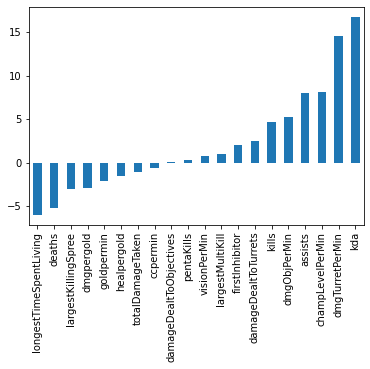

In [10]:
pd.Series(lr.coef_[0], index=X.columns).sort_values().plot(kind='bar');

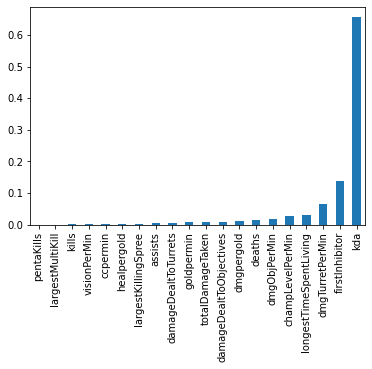

In [11]:
pd.Series(dt.feature_importances_, index=X.columns).sort_values().plot(kind='bar');

## Aggregate at Team Level

In [13]:
columns = ('kda','dmgTurretPerMin','dmgpergold','dmgObjPerMin','visionPerMin','goldpermin','champLevelPerMin','ccpermin','healpergold')
print(columns)
d = dict.fromkeys(columns, ['mean', 'min','max'])
team = df.groupby(['gameId', 'teamId']).agg(d)
team['win'] = df.groupby(['gameId', 'teamId']).agg({'win':"mean"})
team['firstInhibitor'] = df.groupby(['gameId', 'teamId']).agg({'firstInhibitor':"max"})
data2 = team.reset_index()
data2 = data2.drop(['gameId','teamId'], axis=1)
data2.head(10)

('kda', 'dmgTurretPerMin', 'dmgpergold', 'dmgObjPerMin', 'visionPerMin', 'goldpermin', 'champLevelPerMin', 'ccpermin', 'healpergold')


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


kda                      dmgTurretPerMin                         \
       mean       min        max            mean        min         max   
0  1.894589  0.933333   3.250000       78.647230   0.000000  305.897543   
1  4.190909  2.454545   8.750000      154.805498  25.439400  435.593503   
2  1.873333  1.000000   2.666667       56.735672   0.000000  109.888794   
3  4.136667  1.250000  12.000000      160.773311   0.000000  326.535500   
4  3.844502  2.727273   5.166667      113.505470  18.665208  285.776805   
5  2.369475  0.611111   5.000000       86.595186  12.363239  208.774617   
6  5.208333  2.750000   9.000000       76.924605   6.176072  208.063205   
7  2.804298  0.923077   4.400000       93.941309  11.160271  255.060948   
8  0.200000  0.000000   1.000000       18.284483   0.000000   46.810345   
9  4.500000  1.500000   6.000000      188.017241  35.172414  641.831897   

  dmgpergold                     dmgObjPerMin  ... champLevelPerMin            \
        mean       min       max         mean  ...              min       max   
0   2.183378  1.216581  2.983748   184.053311  ...         0.374844  0.449813   
1   1.666162  1.092850  2.252382   398.069138  ...         0.424823  0.449813   
2   1.266547  0.873721  1.674929    86.473909  ...         0.410607  0.615911   
3   1.028626  0.872506  1.107294   500.848589  ...         0.513259  0.615911   
4   2.718694  2.573057  2.887947   277.855580  ...         0.371991  0.393873   
5   2.040106  1.162436  3.146150   449.072210  ...         0.371991  0.393873   
6   2.256861  1.257140  3.186229   143.339052  ...         0.352144  0.460497   
7   2.036909  1.336125  2.704954   415.373363  ...         0.379233  0.460497   
8   0.731953  0.232132  1.231563    72.956897  ...         0.387931  0.646552   
9   0.755504  0.493521  0.965062   293.806034  ...         0.517241  0.711207   

   ccpermin                     healpergold                        win  \
       mean       min       max        mean       min       max          
0  0.649729  0.224906  1.024573    0.320703  0.086974  0.639744  False   
1  0.779675  0.274885  1.299459    0.884127  0.121138  2.516655   True   
2  0.810950  0.102652  1.950385    0.378983  0.009140  1.549750  False   
3  0.677502  0.205304  1.283148    0.467367  0.103351  1.392509   True   
4  1.417943  0.175055  3.019694    0.867898  0.084053  1.650781   True   
5  0.879650  0.196937  1.881838    0.851786  0.249130  1.608144  False   
6  0.996840  0.189616  1.544018    1.310889  0.171635  3.268707  False   
7  1.023928  0.514673  1.977427    1.633849  0.257747  4.603926   True   
8  0.193966  0.000000  0.452586    0.356773  0.007866  0.926496  False   
9  0.918103  0.129310  2.068966    0.293054  0.067360  0.822007   True   

  firstInhibitor  
                  
0          False  
1           True  
2          False  
3           True  
4           True  
5          False  
6          False  
7           True  
8          False  
9          False  

[10 rows x 29 columns]

In [14]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30926 entries, 0 to 30925
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   (kda, mean)               30926 non-null  float64
 1   (kda, min)                30926 non-null  float64
 2   (kda, max)                30926 non-null  float64
 3   (dmgTurretPerMin, mean)   30926 non-null  float64
 4   (dmgTurretPerMin, min)    30926 non-null  float64
 5   (dmgTurretPerMin, max)    30926 non-null  float64
 6   (dmgpergold, mean)        30926 non-null  float64
 7   (dmgpergold, min)         30926 non-null  float64
 8   (dmgpergold, max)         30926 non-null  float64
 9   (dmgObjPerMin, mean)      30926 non-null  float64
 10  (dmgObjPerMin, min)       30926 non-null  float64
 11  (dmgObjPerMin, max)       30926 non-null  float64
 12  (visionPerMin, mean)      30926 non-null  float64
 13  (visionPerMin, min)       30926 non-null  float64
 14  (visio

In [15]:
X = data2.drop(['win'], axis=1)
y = data2.loc[:, "win"]

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# scale
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# benchmark models
lr = LogisticRegression(max_iter=500)
dt = DecisionTreeClassifier(max_depth=6, random_state=42)

lr.fit(X_train_scaled, y_train)
dt.fit(X_train_scaled, y_train)

# 0.9607093866353126
print('Logistic Regression - Train', lr.score(X_train_scaled, y_train))
print('Logistic Regression - Test', lr.score(X_test_scaled, y_test))
print(classification_report(y_test, lr.predict(X_test_scaled)))

# 0.9625710366451107
print('Decision Tree - Train', dt.score(X_train_scaled, y_train))
print('Decision Tree - Test', dt.score(X_test_scaled, y_test))
print(classification_report(y_test, dt.predict(X_test_scaled)))

Logistic Regression - Train 0.9635617760617761
Logistic Regression - Test 0.961395257691554
              precision    recall  f1-score   support

       False       0.95      0.97      0.96      5099
        True       0.97      0.95      0.96      5107

    accuracy                           0.96     10206
   macro avg       0.96      0.96      0.96     10206
weighted avg       0.96      0.96      0.96     10206

Decision Tree - Train 0.9717664092664092
Decision Tree - Test 0.9622770919067215
              precision    recall  f1-score   support

       False       0.96      0.97      0.96      5099
        True       0.97      0.96      0.96      5107

    accuracy                           0.96     10206
   macro avg       0.96      0.96      0.96     10206
weighted avg       0.96      0.96      0.96     10206



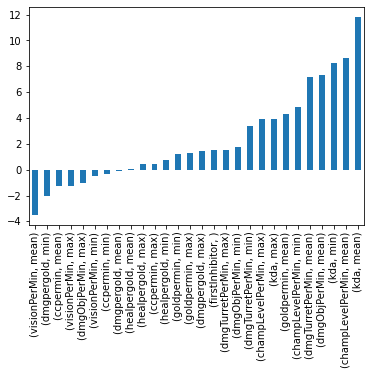

In [16]:
pd.Series(lr.coef_[0], index=X.columns).sort_values().plot(kind='bar');

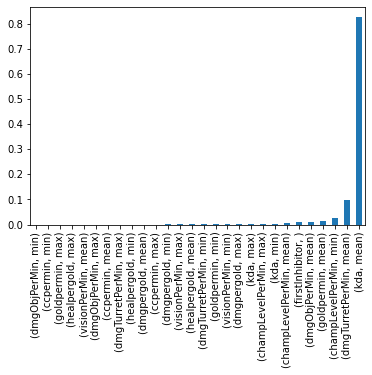

In [17]:
pd.Series(dt.feature_importances_, index=X.columns).sort_values().plot(kind='bar');